In [ ]:
!pip install kornia advertorch
!nvidia-smi

Thu Dec  3 14:29:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    37W / 250W |   9647MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
from torchsummary import summary

from advertorch.attacks import GradientSignAttack,GradientAttack,LinfPGDAttack

import timeit
from itertools import product
import time
import kornia
import numpy as np
from numba import njit
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(7*7*64, 200)
        self.relu3 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(200, 10)

        

    def forward(self, x):
        out = self.maxpool1(self.relu1(self.conv1(x)))
        out = self.maxpool2(self.relu2(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out = self.relu3(self.linear1(out))
        out = self.linear2(out)
        return out

In [ ]:
def Block_Shuffle(block):
  ord = torch.randperm(block.numel())
  block = block.reshape(-1)[ord].reshape(block.shape)
  return block

In [ ]:
"""
takes an image (CxHXW) and shuffles pixels
"""
@njit 
def Pixel_Shuffle(batch,block_size=2):

  it = int(batch.shape[2]/block_size)
  for i in range(batch.shape[0]) :
    for j in range(it**2) :

      row = int(j/it)*block_size
      col = (j%it)*block_size
      batch[i,0,row:row+block_size,col:col+block_size] = np.random.permutation(np.ravel(batch[i,0,row:row+block_size,col:col+block_size])).reshape(block_size,block_size)
  

In [ ]:
device = 'cuda'
batch_size =128
test_batch_size = 64
test_batch_test_all = 10000
epochs = 15
learning_rate = 5e-4
weight_decay =  0

In [ ]:
train_dataset = datasets.MNIST(root='../data/',train=True, download=True, 
    transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='../data/', train=False, download=True, 
    transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=test_batch_size, shuffle=True)

NameError: ignored

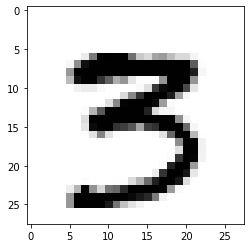

In [ ]:
for X_train, y_train in train_loader:
  #X_train = X_train.to(device)
  break
plt.imshow(X_train[5].squeeze().cpu(),cmap="Greys")

In [ ]:
y = np.arange(36).reshape(6,6)
y

In [ ]:
np.array(np.split(np.array(np.vsplit(y,3)),3,2))

In [ ]:
z = np.array(np.split(np.array(np.vsplit(y,3)),3,2)).reshape(-1,2,2) #function.
np.hstack(np.array(np.vsplit(np.vstack(z),3)))  #inverse of the function.

In [ ]:
Pixel_Shuffle(X_train.cpu().numpy(),3)
X_train = X_train.to(device)

cuda:0


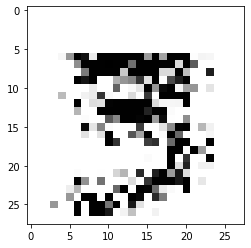

In [ ]:
plt.imshow(X_train[5].squeeze().cpu(),cmap="Greys")
print(X_train.device)

In [ ]:
model = LeNet5()
model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)

In [ ]:
#define loss and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.25,patience=1)

In [ ]:
start = time.time()
y_pred = model(X_train)
optimizer.zero_grad()
loss = criterion(y_pred,y_train)
loss.backward()
optimizer.step()
end = time.time()
print(end-start)

0.011433839797973633


In [ ]:
#FOR LOOP EPOCHS
#train the model
import time
start_time = time.time()


#VARIABLES,TRACKERS
for i in range(epochs):

  for j,(X_train,y_train) in enumerate(train_loader):
    
    j+=1

    #TRAIN
    Pixel_Shuffle(X_train.numpy(),3)
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    #Pixel_Shuffle(X_train)
    
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step(loss)

    if j% 250== 0:
      print(f'epoch {i} : batch  {j} : loss {loss.item()}')
      #plt.imshow(X_train[5].squeeze().cpu(),cmap="Greys")
      
current_time = time.time()
print(f'the model took {(current_time-start_time)/60} minutes to train')

epoch 0 : batch  250 : loss 0.3954036235809326
epoch 1 : batch  250 : loss 0.14180517196655273
epoch 2 : batch  250 : loss 0.12442287802696228
epoch 3 : batch  250 : loss 0.10369641333818436
epoch 4 : batch  250 : loss 0.10235367715358734
epoch 5 : batch  250 : loss 0.09462524205446243
epoch 6 : batch  250 : loss 0.0896424651145935
epoch 7 : batch  250 : loss 0.0786946564912796
epoch 8 : batch  250 : loss 0.034002188593149185
epoch 9 : batch  250 : loss 0.10342583805322647
epoch 10 : batch  250 : loss 0.01757671684026718
epoch 11 : batch  250 : loss 0.060424018651247025
epoch 12 : batch  250 : loss 0.02800598368048668
epoch 13 : batch  250 : loss 0.09382610768079758
epoch 14 : batch  250 : loss 0.033497393131256104
the model took 2.7287978688875834 minutes to train


Test accuracy Basic: 9824/10000 =  98.240%


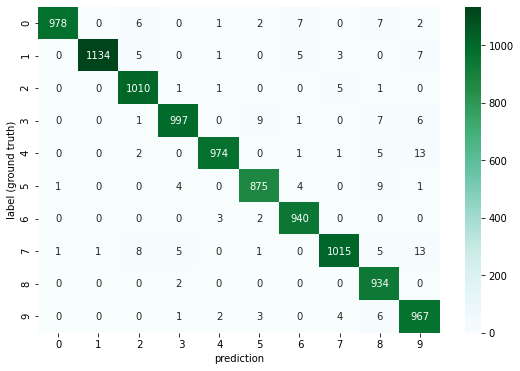

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_test_all, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:

        Pixel_Shuffle(X_test.numpy())
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

        break
        
print(f'Test accuracy Basic: {correct.item()}/{test_batch_test_all} = {correct.item()*100/(test_batch_test_all):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

Test accuracy Basic: 408/10000 =   4.080%


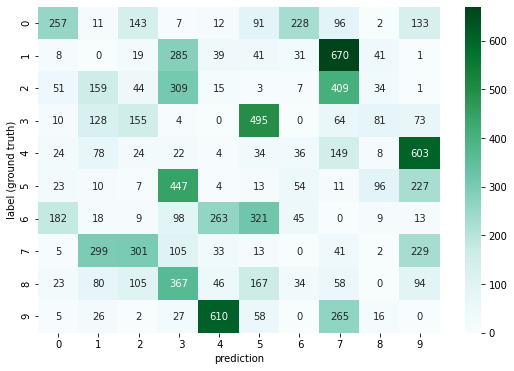

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_test_all, shuffle=False)

correct = 0
for X_test, y_test in test_load_all:
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    adversary = LinfPGDAttack(model,loss_fn=nn.CrossEntropyLoss(),eps=45/255,clip_min=0.0,clip_max=1.0)
    X_adv= adversary.perturb(X_test,y_test) 
    y_val = model(X_adv)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()
    break
        
print(f'Test accuracy Basic: {correct.item()}/{test_batch_test_all} = {correct.item()*100/(test_batch_test_all):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

Test accuracy Basic: 593/10000 =   5.930%


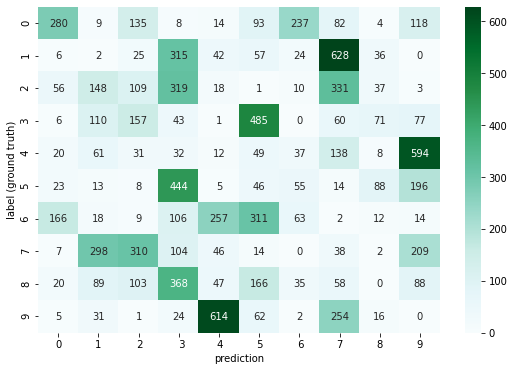

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_test_all, shuffle=False)

correct = 0
for X_test, y_test in test_load_all:
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    adversary = LinfPGDAttack(model,loss_fn=nn.CrossEntropyLoss(),eps=50/255,clip_min=0.0,clip_max=1.0)
    X_adv= adversary.perturb(X_test,y_test)
    X_adv = X_adv.to('cpu') 
    Pixel_Shuffle(X_adv.numpy(),3)
    X_adv = X_adv.to(device)
    y_val = model(X_adv)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()
    break
        
print(f'Test accuracy Basic: {correct.item()}/{test_batch_test_all} = {correct.item()*100/(test_batch_test_all):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
for X_test,y_test in test_load_all:
  X_test = X_test.to(device)
  y_test=y_test.to(device)
  break
adversary = LinfPGDAttack(model.cuda(),loss_fn=nn.CrossEntropyLoss(),eps=50/255,clip_min=0.0,clip_max=1.0)
X_adv= adversary.perturb(X_test,y_test)
X_test = X_test.to('cpu')
X_adv = X_adv.to('cpu')

torch.return_types.max(values=tensor(14.5197, device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor(7, device='cuda:0'))

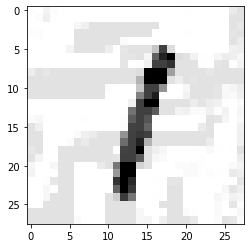

In [ ]:
plt.imshow(X_adv[5].squeeze(),cmap="Greys")
torch.max(model(X_adv.cuda())[5],0)

In [ ]:
Pixel_Shuffle(X_adv.numpy(),3)

torch.return_types.max(values=tensor(4.8546, device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor(7, device='cuda:0'))

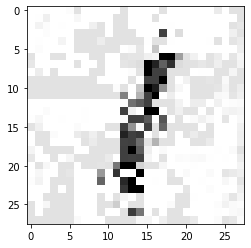

In [ ]:
plt.imshow(X_adv[5].squeeze().cpu(),cmap="Greys")
torch.max(model(X_adv.cuda())[5],0)